## Neural Matrix Factorization

This notebook would correspond to section 3.4 (Fusion of GMF and MLP) in [Xiangnan He, et al 2016](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf) paper. Here we combine the models describled in Chapters 2 and 3, GMF and MLP respectively

As always, let's start by loading the require packages and define a series of variables

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import argparse
import heapq

from time import time
from scipy.sparse import load_npz
from torch import nn
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader, Dataset
from utils import get_train_instances, get_scores
from gmf import GMF, train, evaluate, checkpoint
from mlp import MLP

In [14]:
datadir = "../datasets/Amazon"
dataname = "neuralcf_split.npz"
train_matrix = "neuralcf_train_sparse.npz"
modeldir = "../datasets/Amazon/models"

epochs = 1
batch_size = 512
lr = 0.01
learner = "Adam"
lr_scheduler = None

n_emb = 8

layers = [128, 64, 32]
dropouts = [0., 0.]

freeze = True

# I have run a number of experiments and I know which models to combine...keep reading for more information
mf_pretrain = os.path.join(modeldir, "GMF_bs_1024_lr_001_n_emb_8_lrnr_adam_lrs_wolrs_BCELoss.pt")
mlp_pretrain = os.path.join(modeldir, "MLP_bs_1024_reg_00_lr_003_n_emb_64_ll_32_dp_wodp_lrnr_adam_lrs_wlrs_loss_BCE.pt")

l2reg = 0.

validate_every = 1
save_model = True
n_neg = 4
topk = 10

You will see that I am using a parameter called `freeze`, which is set to `True`. This indicates that I will use pretrained models and I will freeze all but the last linear layer of the model. The pretrained models will be

    GMF_bs_1024_lr_001_n_emb_8_lrnr_adam_lrs_wolrs_BCELoss.pt
 
and 

    MLP_bs_1024_reg_00_lr_003_n_emb_64_ll_32_dp_wodp_lrnr_adam_lrs_wlrs_loss_BCE.pt
    
These names can be read as follow: GMF model, for that experiment I used a batch size of 1024, learning rate of 0.01, embedding dimension 8, learner is Adam and withour scheduler. Or in the case of the MLP: MLP model with batch size 1024, no regularization, learning rate 0.03, 64dim embeddings, last layer (`ll`) of 32 neurons (this means that layers is [128, 64, 32]), without dropout, using Adam and learning rate scheduler.   
  
Let's see how the overal Model looks

### The Model

In [15]:
class NeuMF(nn.Module):
    def __init__(self, n_user, n_item, n_emb, layers, dropouts):
        super(NeuMF, self).__init__()

        self.layers = layers
        self.n_layers = len(layers)
        self.dropouts = dropouts
        self.n_user = n_user
        self.n_item = n_item

        self.mf_embeddings_user = nn.Embedding(n_user, n_emb)
        self.mf_embeddings_item = nn.Embedding(n_item, n_emb)

        self.mlp_embeddings_user = nn.Embedding(n_user, layers[0]//2)
        self.mlp_embeddings_item = nn.Embedding(n_item, layers[0]//2)
        self.mlp = nn.Sequential()
        for i in range(1,self.n_layers):
            self.mlp.add_module("linear%d" %i, nn.Linear(layers[i-1],layers[i]))
            self.mlp.add_module("relu%d" %i, torch.nn.ReLU())
            self.mlp.add_module("dropout%d" %i , torch.nn.Dropout(p=dropouts[i-1]))

        self.out = nn.Linear(in_features=n_emb+layers[-1], out_features=1)

        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight)

    def forward(self, users, items):

        mf_user_emb = self.mf_embeddings_user(users)
        mf_item_emb = self.mf_embeddings_item(items)

        mlp_user_emb = self.mlp_embeddings_user(users)
        mlp_item_emb = self.mlp_embeddings_item(items)

        mf_emb_vector = mf_user_emb*mf_item_emb
        mlp_emb_vector = torch.cat([mlp_user_emb,mlp_item_emb], dim=1)
        mlp_emb_vector = self.mlp(mlp_emb_vector)

        emb_vector = torch.cat([mf_emb_vector,mlp_emb_vector], dim=1)
        preds = torch.sigmoid(self.out(emb_vector))

        return preds

In [16]:
import hiddenlayer as hl

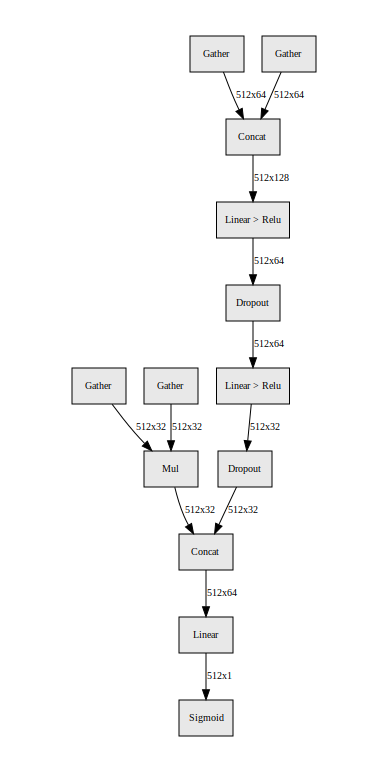

In [17]:
toy_model = NeuMF(n_user=10, n_item=10, n_emb=32, layers=layers, dropouts=dropouts)
hl.build_graph(toy_model, (torch.zeros([batch_size]).long(),  torch.zeros([batch_size]).long()) )

Easy! :) 

### Load Pretrained Models

In [18]:
# Load the dataset
dataset = np.load(os.path.join(datadir, dataname))
train_ratings = load_npz(os.path.join(datadir, train_matrix)).todok()
test_ratings, negatives = dataset['test_negative'], dataset['negatives']
n_users, n_items = dataset['n_users'].item(), dataset['n_items'].item()

test_loader = DataLoader(dataset=test_ratings,
    batch_size=1000,
    shuffle=False
    )

In [19]:
# Define model structures
gmf_model = GMF(n_users, n_items, n_emb)
gmf_model.load_state_dict(torch.load(mf_pretrain))
mlp_model = MLP(n_users, n_items, layers, dropouts)
mlp_model.load_state_dict(torch.load(mlp_pretrain))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Let's have a look and check all went well

In [20]:
gmf_model

GMF(
  (embeddings_user): Embedding(123960, 8)
  (embeddings_item): Embedding(50052, 8)
  (out): Linear(in_features=8, out_features=1, bias=True)
)

In [21]:
mlp_model

MLP(
  (embeddings_user): Embedding(123960, 64)
  (embeddings_item): Embedding(50052, 64)
  (mlp): Sequential(
    (linear1): Linear(in_features=128, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0)
    (linear2): Linear(in_features=64, out_features=32, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.0)
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [22]:
model = NeuMF(n_users, n_items, n_emb, layers, dropouts)
model

NeuMF(
  (mf_embeddings_user): Embedding(123960, 8)
  (mf_embeddings_item): Embedding(50052, 8)
  (mlp_embeddings_user): Embedding(123960, 64)
  (mlp_embeddings_item): Embedding(50052, 64)
  (mlp): Sequential(
    (linear1): Linear(in_features=128, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0)
    (linear2): Linear(in_features=64, out_features=32, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.0)
  )
  (out): Linear(in_features=40, out_features=1, bias=True)
)

Let's now load layer by layer to the NeuMF model 

In [23]:
# GMF embeddings
model.mf_embeddings_item.weight = gmf_model.embeddings_item.weight
model.mf_embeddings_user.weight = gmf_model.embeddings_user.weight

In [24]:
# MLP embeddings
model.mlp_embeddings_item.weight = mlp_model.embeddings_item.weight
model.mlp_embeddings_user.weight = mlp_model.embeddings_user.weight

In [25]:
# MLP layers
model_dict = model.state_dict()
mlp_layers_dict = mlp_model.state_dict()
mlp_layers_dict = {k: v for k, v in mlp_layers_dict.items() if 'linear' in k}
model_dict.update(mlp_layers_dict)
model.load_state_dict(model_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [26]:
# Prediction weights
mf_prediction_weight, mf_prediction_bias = gmf_model.out.weight, gmf_model.out.bias
mlp_prediction_weight, mlp_prediction_bias = mlp_model.out.weight, mlp_model.out.bias

new_weight = torch.cat([mf_prediction_weight, mlp_prediction_weight], dim=1)
new_bias = mf_prediction_bias + mlp_prediction_bias
model.out.weight = torch.nn.Parameter(0.5*new_weight)
model.out.bias = torch.nn.Parameter(0.5*new_bias)

And that's it, Now our model is fully loaded with pretrained weights. In case you are wondering why do I multiply by 0.5 the contribution from each model, the answer is pretty straightforward, but just in case, let me explain. Let's stay that the outputs from GMF and MLP are identical, for example 0.7. Therefore, when the two models are combined one would expect "full agreement", meaning that the output of the combined model (NeuMF) is also 0.7. 

The fact that the GMF output 0.7 means that the summation of the weights in the output layer is

In [27]:
p = 0.7
logit_p = np.log(p/(1-p))
print(logit_p)

0.8472978603872034


And the same applies to the MLP model. Therefore, since we need the output of the NeuMF to also be `0.8473`, we need to add the (GMF_out/2 + MLP_out/2)

### Freeze all up to Last (output) Layer

This is rather easy

In [28]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

if freeze:
    for name, layer in model.named_parameters():
        if not ("out" in name):
            layer.requires_grad = False
# or this and pass train_parametes to the optimizer
# train_parametes = model.out.parameters() if freeze else model.parameters()

### Run the Model

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2reg)

criterion = nn.BCELoss()

scheduler = None

# let's make sure all is ok
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
trainable_params = sum([np.prod(p.size()) for p in model_parameters])
print(trainable_params)

41


All ok, 40 (32+8) weights + a bias is all that we will be training here

In [30]:
best_hr, best_ndcgm, best_iter=0,0,0
for epoch in range(1,epochs+1):
    t1 = time()
    loss = train(model, criterion, optimizer, scheduler, epoch, batch_size,
        use_cuda, train_ratings, negatives, n_items, n_neg)
    t2 = time()
    if epoch % validate_every == 0:
        (hr, ndcg) = evaluate(model, test_loader, use_cuda, topk)
        print("Epoch: {} {:.2f}s, LOSS = {:.4f}, HR = {:.4f}, NDCG = {:.4f}, validated in {:.2f}s".
            format(epoch, t2-t1, loss, hr, ndcg, time()-t2))

Epoch: 1 90.97s, LOSS = 0.1615, HR = 0.6960, NDCG = 0.4759, validated in 105.08s


Nice resulst! For a full summary of the results, go to Chapter05